In [1]:
!pip install pycuda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pycuda.autoinit
import numpy as np
import sys
from pycuda import gpuarray
from pycuda.compiler import SourceModule
from time import time
import math
import matplotlib.pyplot as plt

# shared.py

In [3]:
import numpy as np
from pycuda import gpuarray
import math
import sys

class Shared:
    def __init__(self, A, b, learning_rate, beta=0, constrained=None):
        ## input matrix's shape
        self.length = A.shape[0]
        self.width = A.shape[1]
        
        ## in CPU
        self.A = np.float32(A)
        self.b = np.float32(b)
        self.theta = np.float32(np.zeros(self.width))
        self.out = np.float32(np.zeros(self.length))
        self.grad = np.float32(np.zeros(self.width))

        ## in GPU
        self.GPU_A = gpuarray.to_gpu(self.A.reshape(self.length*self.width))
        self.GPU_b = gpuarray.to_gpu(self.b)
        self.GPU_theta = gpuarray.to_gpu(self.theta)
        self.GPU_out = gpuarray.to_gpu(self.out)
        self.GPU_grad = gpuarray.to_gpu(self.grad)

        ## for initialize out vector and grad vector
        self.init_out = gpuarray.empty_like(self.GPU_out)
        self.init_grad = gpuarray.empty_like(self.GPU_grad)

        ## TPB: thread_per_block, BPG: block_per_grid        
        self.TPB, self.BPG = self.optimal_block_size(self.length)

        ## learning_rate
        self.learning_rate = learning_rate

        ## for constrained lstsq
        if not constrained:
            pass

        else:
            self.constrained_unpacking(constrained)

    def optimal_block_size(self, n):
        
        thread_per_block = int(math.sqrt(n / 2))

        block_per_grid = int(n / thread_per_block) + 1


        return thread_per_block, block_per_grid

    def constrained_unpacking(self, constrained):
        self.constrained = np.zeros((2,self.width))
        self.constrained[0,:] += sys.float_info.max
        self.constrained[1,:] -= sys.float_info.max

        for i in range(constrained.shape[0]):
            index = constrained[0,i]
            if not constrained[1,i]:
                self.constrained[0,index] = constrained[1,i]
            else:
                pass

            if not constrained[2,i]:
                self.constrained[1,index] = constrained[2,i]
            else:
                pass

        self.constrained = np.float32(self.constrained)

        self.GPU_constrained = gpuarray.to_gpu(self.constrained)

    def momentum(self, beta):
        self.beta = beta

    def nesterov(self, beta):
        self.GPU_velocity = gpuarray.empty_like(self.GPU_theta)
        self.beta = beta

# get_gradient.py

In [4]:
class GetGradient:
    def __init__(self, shared):
       self.shared = shared
       
       self.kernel_function()

    def run(self):

        self.initialize()

        ## get out = np.dot(A, theta) - b
        self.first(self.shared.GPU_out,
                   self.shared.GPU_A,
                   self.shared.GPU_theta,
                   self.shared.GPU_b,
                   np.int32(self.shared.length),
                   np.int32(self.shared.width),
                   block=(self.shared.TPB,1,1),
                   grid=(self.shared.BPG,1,1))

        ## get grad = np.dot(A.T, out)
        self.second(self.shared.GPU_grad,
                   self.shared.GPU_A,
                   self.shared.GPU_out,
                   np.int32(self.shared.TPB),
                   np.int32(self.shared.BPG),
                   np.int32(self.shared.length),
                   np.int32(self.shared.width),
                   block=(self.shared.BPG,1,1),
                   grid=(self.shared.width,1,1))
                   
                   

    def kernel_function(self):
        ## block=(thread_per_block,1,1), grid=(block_per_grid,1,1)
        first_ker_function = \
        """
        #define x (threadIdx.x + blockIdx.x * blockDim.x)

        __global__ void first(float* out, float* A, float* theta, float* b, int length, int width) {
            
            if (x < length) {
                for (int j = 0; j < width; j++) {
                    int index1 = x * width + j;

                    out[x] += A[index1] * theta[j];
                    }

                out[x] -= b[x];
            }
        }
        """
        first_ker = SourceModule(first_ker_function)



        ## block=(block_per_grid,1,1), grid=(width,1,1)
        second_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)

        __global__ void second(float* grad, float* A, float* out, int thread_per_block, int block_per_grid, int length, int width) {

            __shared__ float grad_jerk[1000];

            grad_jerk[tx] = 0;

            __syncthreads();
            
            for (int i = 0; i < thread_per_block; i++) {
                int index1 = tx * thread_per_block + i;
                int index2 = index1 * width + bx;
                
                grad_jerk[tx] += A[index2] * out[index1];
            }

            __syncthreads();

            if (tx == 0) {
                for (int i = 0; i < block_per_grid; i++) {
                    grad[bx] += grad_jerk[i];
                }
            }
            else {
                grad_jerk[1000-tx] = 0;
            }

            __syncthreads();
        }
        """
        second_ker = SourceModule(second_ker_function)

        self.first = first_ker.get_function("first")
        self.second = second_ker.get_function("second")

    def initialize(self):
        self.shared.GPU_out[:] = self.shared.init_out[:]

# optimizer.py

In [5]:
import numpy as np
from pycuda.compiler import SourceModule

class Optimizer:
    def __init__(self, shared):
        self.shared = shared

    def run(self):
        return NotImplementedError()

    def kernel_function(self):

        ## block=(width,1,1), grid=(1,1,1)
        constrained_projection_ker_function = \
        """
        #define x (threadIdx.x)

        __global__ void constrained_projection (float* theta, float* constrained, int width) {
            int upper = x;
            int downer = x + width;

            if (theta[x] > constrained[upper]){
                if (theta[x] > constrained[downer]) {
                    theta[x] = constrained[upper];
                }
                else {}
            }
            else {
                if (theta[x] < constrained[downer]) {
                    theta[x] = constrained[downer];
                }
                else {}
            }
        }
        """
        constrained_projection_ker = SourceModule(constrained_projection_ker_function)

        self.constrained_projection = constrained_projection_ker.get_function("constrained_projection")

    def initialize(self):
        return NotImplementedError()



class GradientMethod(Optimizer):
    def __init__(self, shared):
        super().__init__(shared)
        # super().kernel_function()

        self.kernel_function()

    def run(self):

        self.gradient_method(self.shared.GPU_theta,
                             self.shared.GPU_grad,
                             np.float32(self.shared.learning_rate),
                             block=(self.shared.width,1,1),
                             grid=(1,1,1))

        self.initialize()
        
    def kernel_function(self):

        ## block=(width,1,1), grid=(1,1,1)
        gradient_method_ker_function = \
        """
        #define x (threadIdx.x)

        __global__ void gradient_method (float* theta, float* grad, float learning_rate) {
            theta[x] -= learning_rate * grad[x];

            __syncthreads();
        }
        """
        gradient_method_ker = SourceModule(gradient_method_ker_function)

        self.gradient_method = gradient_method_ker.get_function("gradient_method")

    def initialize(self):
        self.shared.GPU_grad[:] = self.shared.init_grad[:]



class MomentumMethod(Optimizer):
    def __init__(self, shared):
        super().__init__(shared)
        # super().kernel_function()

        self.kernel_function()

    def run(self):

        self.momentum_method(self.shared.GPU_theta,
                             self.shared.GPU_grad,
                             np.float32(self.shared.learning_rate),
                             block=(self.shared.width,1,1),
                             grid=(1,1,1))
                             
        self.initialize()

    def kernel_function(self):

        ## block=(width,1,1), grid=(1,1,1)
        momentum_method_ker_function = \
        """
        #define x (threadIdx.x)

        __global__ void momentum_method (float* theta, float* grad, float learning_rate) {
            theta[x] -= learning_rate * grad[x];

            __syncthreads();
        }
        """
        momentum_method_ker = SourceModule(momentum_method_ker_function)
        
        ## block=(width,1,1), grid=(1,1,1)
        momentum_ker_function = \
        """
        #define x (threadIdx.x)

        __global__ void momentum (float* grad, float beta) {

            grad[x] *= beta;
        }
        """
        momentum_ker = SourceModule(momentum_ker_function)

        self.momentum_method = momentum_method_ker.get_function("momentum_method")
        self.momentum = momentum_ker.get_function("momentum")

    def initialize(self):
        self.momentum(self.shared.GPU_grad,
                      np.float32(self.shared.beta),
                      block=(self.shared.width,1,1),
                      grid=(1,1,1))
                      


class NesterovMethod(Optimizer):
    def __init__(self, shared):
        super().__init__(shared)
        # super().kernel_function()

        self.kernel_function()
        
        self.iter = 0

    def run(self):

        self.nesterov_method(self.shared.GPU_velocity,
                             self.shared.GPU_theta,
                             self.shared.GPU_grad,
                             np.float32(self.shared.learning_rate),
                             np.float32(self.shared.beta),
                             block=(self.shared.width,1,1),
                             grid=(1,1,1))

        self.initialize()

        self.iter += 1

    def kernel_function(self):

        ## block=(width,1,1), grid=(1,1,1)
        ## theta = y - alpha*grad(y)
        nesterov_method_ker_function = \
        """
        #define x (threadIdx.x)
        __global__ void nesterov_method (float* velocity, float* theta, float* grad, float learning_rate, float beta) {
            
            theta[x] += beta * velocity[x] - learning_rate * grad[x];

            __syncthreads();
        }
        """
        nesterov_method_ker = SourceModule(nesterov_method_ker_function)

        ## block=(width,1,1), grid=(1,1,1)
        nesterov_ker_function = \
        """
        #define x (threadIdx.x)

        __global__ void nesterov (float* theta, float* velocity, float beta) {
            
            theta[x] += beta * velocity[x];
            
            __syncthreads();
        }
        """
        nesterov_ker = SourceModule(nesterov_ker_function)

        self.nesterov_method = nesterov_method_ker.get_function("nesterov_method")
        self.nesterov = nesterov_ker.get_function("nesterov")
        
    def initialize(self):
        
        self.nesterov(self.shared.GPU_theta,
                      self.shared.GPU_velocity,
                      np.float32(self.shared.beta),
                      block=(self.shared.width,1,1),
                      grid=(1,1,1))

# solver.py

In [25]:
class LeastSquare:
    def __init__(self, A, b, learning_rate, beta=0, epoches=10, iteration=5, optimize_method="GD", constrained=None):
        ## shared
        self.shared = Shared(A, b, learning_rate, beta=beta)

        ## gradient
        self.get_gradient = GetGradient(self.shared)
        
        ## optimizer
        if optimize_method == "GD":
            self.optimizer = GradientMethod(self.shared)
        
        elif optimize_method == "momentum":
            self.optimizer = MomentumMethod(self.shared)
            self.shared.momentum(beta)

        elif optimize_method == "Nesterov":
            self.optimizer = NesterovMethod(self.shared)
            self.shared.nesterov(beta)
            
        else:
            return NotImplementedError()

        ## epoches, iteration
        self.epoches = epoches
        self.iteration = iteration

        ## constrained
        if constrained == None:
            pass

        else:
            self.shared.constrained_unpacking(constrained)

        ## error log
        self.error = np.zeros(epoches*iteration)

    def solve(self):
        for epoch in range(self.epoches):
            for iter in range(self.iteration):
                ## get gradient
                self.get_gradient.run()

                ## optimize
                self.optimizer.run()

    def solve_with_record(self):
        for epoch in range(self.epoches):
            for iter in range(self.iteration):
                ## record
                self.record_error(epoch, iter)
                
                ## get gradient
                self.get_gradient.run()

                ## optimize
                self.optimizer.run()

    def record_error(self, epoch, iter):
        index = epoch * self.iteration + iter

        self.get_gradient.initialize()

        self.get_gradient.first(self.shared.GPU_out,
                                self.shared.GPU_A,
                                self.shared.GPU_theta,
                                self.shared.GPU_b,
                                np.int32(self.shared.length),
                                np.int32(self.shared.width),
                                block=(self.shared.TPB,1,1),
                                grid=(self.shared.BPG,1,1))
            
        self.error[index] = np.linalg.norm(self.shared.GPU_out.get())

In [65]:
A = np.random.rand(3000,100)
b = np.random.rand(3000)
learning_rate = 3e-6

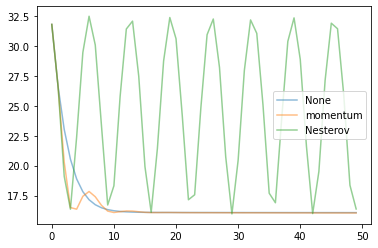

None accelerate: 0.019494295120239258 s
Momentum       : 0.01851058006286621 s
Nesterov       : 0.018461942672729492 s
Minimized error: (15.963889122009277, 89)


In [66]:
error = np.zeros((50,3))

t1 = time()
lstsq = LeastSquare(A, b, learning_rate, iteration=5)
lstsq.solve_with_record()
opt_theta_gpu = lstsq.shared.GPU_theta.get()
t2 = time()
t_none = t2 - t1
error[:,0] = lstsq.error[:]

t1 = time()
lstsq = LeastSquare(A, b, learning_rate, beta=2/3, iteration=5, optimize_method="momentum")
lstsq.solve_with_record()
opt_theta_gpu = lstsq.shared.GPU_theta.get()
t2 = time()
t_momt = t2 - t1
error[:,1] = lstsq.error[:]

t1 = time()
lstsq = LeastSquare(A, b, learning_rate, iteration=5, optimize_method="Nesterov")
lstsq.solve_with_record()
opt_theta_gpu = lstsq.shared.GPU_theta.get()
t2 = time()
t_nest = t2 - t1
error[:,2] = lstsq.error[:]

plt.plot(error[:,0], alpha=0.5, label="None")
plt.plot(error[:,1], alpha=0.5, label="momentum")
plt.plot(error[:,2], alpha=0.5, label="Nesterov")

plt.legend()
plt.show()

print(f"None accelerate: {t_none} s")
print(f"Momentum       : {t_momt} s")
print(f"Nesterov       : {t_nest} s")
print(f"Minimized error: {np.min(error), np.argmin(error)}")

In [63]:
t1 = time()
opt_theta = np.linalg.lstsq(A,b, rcond=None)[0]
t2 =time()

print(f"Duration: {round(t2 - t1, 4)} s")

print(np.linalg.norm(np.dot(A, opt_theta) - b))

Duration: 0.0244 s
15.454396816301536


# Hyper Parameter tuning

In [36]:
class HyperParameterTuning:
    def __init__(self, A, b, optimizer="GD"):

        self.A = A
        self.b = b

        self.lr_upper  = 1 / A.shape[0]
        self.lr_downer = 1 / (A.shape[0] * 100)

        self.result = {}
        self.optimizer = optimizer

        if self.optimizer == "GD":
            self.learning_rate = np.linspace(self.lr_downer, self.lr_upper)

        elif self.optimizer == "momentum":
            self.learning_rate = np.linspace(self.lr_downer, self.lr_upper)
            self.beta = np.linspace(0,1)

        elif self.optimizer == "Nesterov":
            self.learning_rate = np.linspace(self.lr_downer, self.lr_upper)
            self.beta = np.linspace(0,1)

        else:
            pass

        self.parameter = list()

    def run(self):
        if self.optimizer == "GD":
            self.tune_single_parameter()

        elif self.optimizer == "momentum":
            self.tune_double_parameter()

        elif self.optimizer == "Nesterov":
            self.tune_double_parameter()

        else:
            return NotImplementedError()

        self.visualize()
        self.unpacking_key()

    def tune_single_parameter(self):

        for learning_rate in self.learning_rate:
            key = f"learning_rate: {learning_rate}"
            
            lstsq = LeastSquare(self.A, self.b, learning_rate, optimize_method=self.optimizer)
            lstsq.solve_with_record()

            self.result[key] = lstsq.error

    def tune_double_parameter(self):

        for learning_rate in self.learning_rate:
            for beta in self.beta:
                key = f"learning_rate: {learning_rate} beta: {beta}"

                lstsq = LeastSquare(self.A, self.b, learning_rate, beta=beta, optimize_method=self.optimizer)
                lstsq.solve_with_record()

                self.result[key] = lstsq.error

    def visualize(self):
        self.keys       = list()
        self.error_list = list()

        k = 0

        for key, value in sorted(self.result.items(), key=lambda x : x[1][-1]):
            if k < 5:
                self.keys.append(key)
                self.error_list.append(self.result[key])

            else:
                break

            k += 1

        plt.figure(figsize=(15,3))

        ## best 5
        for i in range(5):
            plt.subplot(1,5,i+1)
            plt.plot(self.error_list[i])
            plt.title(f"Best-{i+1}")
            plt.yscale("log")
            plt.xlim(1,50)
            plt.ylim(1,1000)

        plt.show()

        print(self.keys[0])

    def cut_nan_in_single_parameter(self):
        for learning_rate in self.learning_rate:
            key = f"learning_rate: {learning_rate}"

            value = self.result[key]

            if value[-1] == value[-1]:
                pass

            else:
                del self.result[key]

    def cut_nan_in_double_parameter(self):

        ## cut nan values...
        for learning_rate in self.learning_rate:
            for beta in self.beta:
                key = f"learning_rate: {learning_rate} beta: {beta}"

                value = self.result[key]
                
                if value[-1] == value[-1]:
                    pass

                else:
                    del self.result[key]

    def unpacking_key(self):
        best_key = self.keys[0]

        for string in best_key.split():
            try:
                self.parameter.append(float(string))

            except:
                pass

In [12]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/lstsq')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
A = np.random.rand(3000,50)
b = np.random.rand(3000)

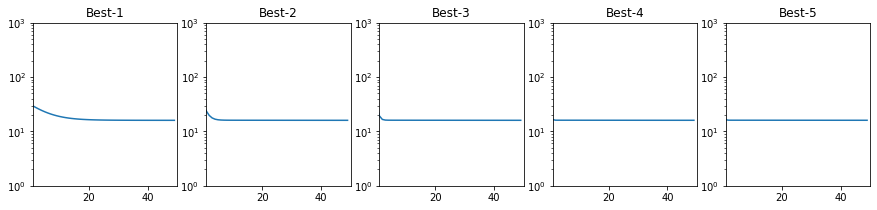

learning_rate: 5.047619047619047e-05


In [38]:
tuning = HyperParameterTuning(A, b, optimizer="GD")

tuning.run()

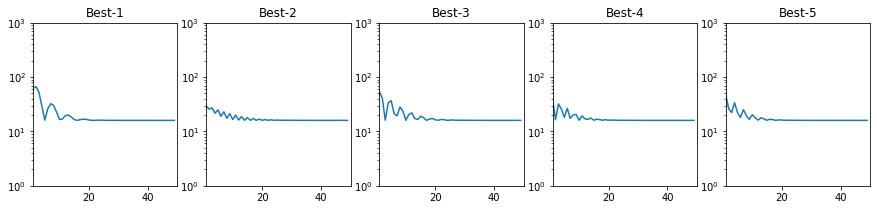

learning_rate: 8.414965986394559e-05 beta: 0.7346938775510203


In [40]:
tuning2 = HyperParameterTuning(A, b, optimizer="momentum")

tuning2.run()

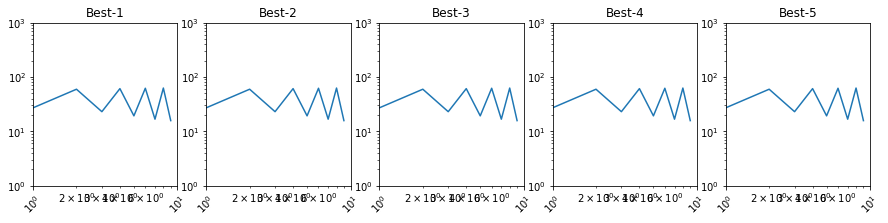

learning_rate: 8.414965986394559e-05, beta: 0.0


In [ ]:
tuning3 = HyperParameterTuning(A, b, optimizer="Nesterov")

tuning3.run()

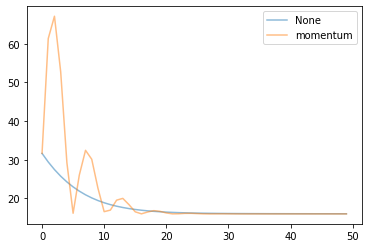

None accelerate: 0.019655227661132812 s
Momentum       : 0.01858973503112793 s
Minimized error: (0.0, 2)


In [42]:
error = np.zeros((50,3))

# GD
learning_rate = tuning.parameter[0]

t1 = time()
lstsq = LeastSquare(A, b, learning_rate)
lstsq.solve_with_record()
opt_theta_gpu = lstsq.shared.GPU_theta.get()
t2 = time()
t_none = t2 - t1
error[:,0] = lstsq.error[:]

# momentum
learning_rate = tuning2.parameter[0]
beta = tuning2.parameter[1]

t1 = time()
lstsq = LeastSquare(A, b, learning_rate, optimize_method="momentum")
lstsq.shared.beta = beta
lstsq.solve_with_record()
opt_theta_gpu = lstsq.shared.GPU_theta.get()
t2 = time()
t_momt = t2 - t1
error[:,1] = lstsq.error[:]


# t1 = time()
# lstsq = LeastSquare(A, b, learning_rate, iteration=5, optimize_method="Nesterov")
# lstsq.solve()
# opt_theta_gpu = lstsq.shared.GPU_theta.get()
# t2 = time()
# t_nest = t2 - t1
# error[:,2] = lstsq.error[:]


plt.plot(error[:,0], alpha=0.5, label="None")
plt.plot(error[:,1], alpha=0.5, label="momentum")
# plt.plot(error[:,2], alpha=0.5, label="Nesterov")

plt.legend()
plt.show()

print(f"None accelerate: {t_none} s")
print(f"Momentum       : {t_momt} s")
# print(f"Nesterov       : {t_nest} s")
print(f"Minimized error: {np.min(error), np.argmin(error)}")